<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/FinRL_PortfolioAllocation_NeurIPS_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Packages

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math
from datetime import datetime
from Data_processor import YahooFinanceProcessor

### Download Data

In [56]:
# 設定資料日期範圍
TRAIN_START_DATE = "2016-01-01"
TRAIN_END_DATE = "2021-01-01"

TEST_START_DATE = "2021-01-01"
TEST_END_DATE = "2022-01-01"

### Data Preprocessing

In [57]:
company = 'aapl'
if company=='aapl':
    ticker_list = ['aapl', 'msft', 'amzn', 'googl', 'fb', 'tsla', 'brk-a', 'v', 'jpm', 'jnj', 'wmt']
elif company=='xom':
    ticker_list = ['xom','lin','mmm','amzn','wmt','jnj','brk-a','aapl','dis','nee','amt']
elif company=='ge':
    ticker_list = ['ge', 'f', 'aapl', 'aal', 'bac', 'ccl', 'amd', 'wfc', 't', 'msft', 'pfe']

ticker_list = ['VLT', 'VTI', 'VNQ']

In [ ]:
# 資料下載與前處理(只包含training範圍的資料)

# 股票代碼與技術指標的list

tech_list = []

# 技術指標與VIX的開關，如果不想加就設定為False
if_vix = False
if_tech = False

# 下載並清洗資料
DP = YahooFinanceProcessor()
train_data = DP.download_data(start_date = TRAIN_START_DATE,end_date = TRAIN_END_DATE,ticker_list = ticker_list, time_interval='1D')
train_data = DP.clean_data(train_data)
test_data = DP.download_data(start_date = TEST_START_DATE,end_date = TEST_END_DATE,ticker_list = ticker_list, time_interval='1D')
test_data = DP.clean_data(test_data)

# 加入技術指標和恐慌指數(如果有的話)
if if_tech:
    tech_list = ['close_30_sma','close_60_sma','macd','boll_ub','boll_lb','dx_30','rsi_30']
    train_data = DP.add_technical_indicator(train_data, tech_list)
    test_data = DP.add_technical_indicator(test_data, tech_list)
if if_vix:
    train_data = DP.add_vix(train_data)
    test_data = DP.add_vix(test_data)
    
# DataFrame轉成np.array
price_array_train, tech_array_train, turbulence_array_train = DP.df_to_array(train_data,tech_list, if_vix, if_tech)
price_array_test, tech_array_test, turbulence_array_test = DP.df_to_array(test_data,tech_list, if_vix, if_tech)

# 加入額外的state資訊 ( RN embedding )
aug_state_array_train = np.zeros((0,0))
aug_state_array_test = np.zeros((0,0))
#aug_state_array_train = np.load('./RN/AAPL_rn_rt4rn_train.npy')
#aug_state_array_test = np.load('./RN/AAPL_rn_rt4rn_test.npy')

# aug_state_array = np.zeros((price_array.shape[0],11,8)) # (754,11,8)


#加入AE的資訊 (AE noise)
# ae_train = np.load('./AE/GE_AE_rt6_train.npy')
# ae_test = np.load('./AE/GE_AE_rt6_test.npy')


# 印一下形狀
print('=============')
print('price_array_train: ',price_array_train.shape)
print('tech_array_train: ',tech_array_train.shape)
print('turbulence_array_train: ',turbulence_array_train.shape)
#print('aug_state_array_train: ',aug_state_array_train.shape)
# print('ae_train:',ae_train.shape)



print('-----------')
print('price_array_test: ',price_array_test.shape)
print('tech_array_test: ',tech_array_test.shape)
print('turbulence_array_test: ',turbulence_array_test.shape)
#print('aug_state_array_test: ',aug_state_array_test.shape)
# print('ae_test:',ae_test.shape)

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- VLT: No data found for this date range, symbol may be delisted


In [ ]:
price_array_train

In [6]:
train_data

,time,open,high,low,close,adjcp,volume,tic
0,2017-01-03,14.280000,14.360000,14.220000,14.340000,8.829056,52500.0,VLT
1,2017-01-04,14.320000,14.400000,14.290000,14.400000,8.865996,7700.0,VLT
2,2017-01-05,14.440000,14.440000,14.370000,14.400000,8.865996,10800.0,VLT
3,2017-01-06,14.420000,14.480000,14.350000,14.400000,8.865996,18800.0,VLT
4,2017-01-09,14.410000,14.430000,14.390000,14.410000,8.872156,36000.0,VLT
...,...,...,...,...,...,...,...,...
3772,2021-12-27,240.479996,242.960007,240.339996,242.960007,240.220520,4395100.0,VTI
3773,2021-12-28,243.059998,243.779999,242.039993,242.460007,239.726166,3960900.0,VTI
3774,2021-12-29,242.550003,243.160004,241.710007,242.600006,239.864578,3044300.0,VTI
3775,2021-12-30,243.110001,243.690002,242.000000,242.210007,239.478989,4501500.0,VTI


## Initiate Agent & Environment 

In [35]:
# 金融交易環境for資產配置
class StockPortfolioEnv:  
    
    # 初始化參數由env_args傳入
    def __init__(self, 
                 price_array, #各公司的股價(調整後收盤價)
                 tech_array, #技術指標陣列
                 #turbulence_array, #vix
                 #aug_state_array, #其他的state(embedding / 時間資訊 / 資產資訊)
                 env_name, #環境名稱
                 lookback, #window size(每次交易看過去幾天),
                ):
        
        initial_capital = 100000
        
        self.lookback = lookback  # 預設看過去10天
        self.initial_total_asset = initial_capital # 初始總資產(股票+現金)
        self.initial_cash = initial_capital #初始現金
        
        self.trans_cost = 0.01 #交易手續費(買賣都一樣)
        self.buy_cost_pct = self.trans_cost # buy手續費
        self.sell_cost_pct = self.trans_cost # sell手續費
        self.gamma = 1 # reward遞減係數
        
        # 載入放入state的陣列
        self.price_array = price_array 
        self.tech_array = tech_array  
        #self.aug_state_array = aug_state_array
#         self.ae_array = ae_array
        #self.turbulence_array = turbulence_array
        
        # 價格轉成daily return 
        self.price_return = pd.DataFrame(self.price_array).pct_change(1).fillna(0).values
        
        # vix轉成r return
        #self.turbulence_array = pd.DataFrame(self.turbulence_array).pct_change(1).fillna(0).values

        
        self.stock_num = self.price_array.shape[1] #有幾隻股票要交易
        self.max_step =  self.price_array.shape[0] - lookback-1 #每個episode最多走幾步(期初走到最後一天)
#         self.max_step = self.price_array.shape[0] - lookback-1
        self.env_num = 1 #有幾個環境(預設為1)
        print('max_step',self.max_step)
        print('self.price_array.shape[0]',self.price_return.shape[0])
        
        # 將環境初始化
        self.time = lookback-1 #現在的時間點
        self.cash = self.initial_cash
        self.current_price = self.price_array[self.time]
        self.current_tech = self.tech_array[self.time] if self.tech_array.shape[0]>0 else self.tech_array
        #self.current_aug_state = self.aug_state_array[self.time] if self.aug_state_array.shape[0]>0 else self.aug_state_array
        self.portfolio = np.zeros(self.stock_num, dtype=np.float32) #現在手上的股票部位
        
        
        # 紀錄訓練的結果
        self.history = {'cumu_return':[],'action':[]}

        # 紀錄現有資產及報酬率
        self.total_asset = self.cash + (self.portfolio * self.price_array[self.time]).sum()
        self.episode_return = 0.0  
        self.gamma_return = 0.0
        

        '''env information'''
        self.env_name = env_name
        self.state_dim = self.price_return.shape[1]*lookback #1 + (self.price_array.shape[1] + self.tech_array.shape[0])*lookback
        self.action_dim = self.price_return.shape[1]+1 #加一維cash
        self.mid_dim = 16 #過完CNN每家公司的embedding長度  
        #self.aug_state_dim = 1
        #self.current_working_dir = current_working_dir
        

        self.if_discrete = False
        self.target_return = 10
        self.total_cumulative_return = []
        
    # softmax
    def action_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        
        return softmax_output

    def reset(self) -> np.ndarray:
        self.time = self.lookback-1
        self.current_price = self.price_array[self.time]
        self.current_tech = self.tech_array[self.time] if self.tech_array.shape[0]>0 else self.tech_array
        #self.current_aug_state = self.aug_state_array[self.time] if self.aug_state_array.shape[0]>0 else self.aug_state_array
        self.cash = self.initial_cash  # reset()
        self.portfolio = np.zeros(self.stock_num, dtype=np.float32) # 持有股數
        self.total_asset = self.cash + np.sum(self.portfolio * self.price_array[self.time]) # 總資產價值
        self.history = {'cumu_return':[],'action':[],'total_asset':[],'episode return':[]}
        self.episode_return = 0.0
        self.gamma_return = 0.0
        state  = self.get_state()
        
        return state

    
    def step(self, actions) -> (np.ndarray, float, bool, None):
        self.time += 1
        #print('time:',self.time)
        """transaction"""
        # 隔一天的weight，包含股票及現金的持有比例
        action = self.action_normalization(actions)
        action = action.reshape(-1)
        
        # 新的持有股數：現在的weight*前一天總資產價值/股價(無條件捨去)
        new_portfolio = np.floor(action[:-1]*self.total_asset/self.price_array[self.time-1])
        
        # 前一天配置股票剩餘資金納入手上現金部位
        self.cash = self.total_asset - sum(new_portfolio*self.price_array[self.time-1])
        
        # 計算手續費
        portfolio_change = np.sum((new_portfolio-self.portfolio)*self.price_array[self.time-1])
        trans_cost = portfolio_change*self.trans_cost
        self.cash-=trans_cost
        
        # 計算新的資產價值
        new_total_asset = np.sum(new_portfolio*self.price_array[self.time])+self.cash
        #print('cash',self.cash)
        
        # 計算報酬率
        portfolio_return = new_total_asset/self.total_asset
        self.cumu_return = new_total_asset/self.initial_total_asset
        reward = (portfolio_return-1)*100
        
        #更新資產狀態
        self.total_asset = new_total_asset
        self.portfolio = new_portfolio
        
        self.gamma_return = self.gamma_return * self.gamma + reward 
        self.cumu_return = self.total_asset / self.initial_cash
        
        self.history['cumu_return'].append(self.cumu_return)
        self.history['action'].append(action)
        self.history['total_asset'].append(self.total_asset)
                
        """update time"""
        done = self.time == self.max_step+self.lookback
        state = self.get_state()
        self.episode_return = self.total_asset / self.initial_total_asset
        if done:
            #print('self.max_step',self.max_step)
            reward = self.gamma_return
            self.episode_return = self.total_asset / self.initial_total_asset
            
            ''' 
            # 畫圖
            plt.plot(self.history['cumu_return'])
            plt.savefig('./train_history/cumulative_return/cumulative_plot'+datetime.now().strftime('%Y-%m-%d %H:%M:%S')+'.png')
            plt.close()
            '''
            
            # 每個episode交易紀錄存檔
            pd.DataFrame(self.history['cumu_return']).to_csv('./train_history_DDPG/cumulative_return/cumu_return'\
                                                             +datetime.now().strftime('%Y-%m-%d %H%M%S')+'.csv')
            pd.DataFrame(self.history['action']).to_csv('./train_history_DDPG/action/action'\
                                                             +datetime.now().strftime('%Y-%m-%d %H%M%S')+'.csv')
        return state, reward, done, None

    def get_state(self):
        # 從現在時間往前取n天(lookback)
#         print(self.time)

        state = self.price_return[self.time-self.lookback+1:self.time+1].reshape(-1)*100 #flatten
        """
        if self.turbulence_array.shape[0]!=0:
            for i in range(self.lookback):
                turbulence_i = self.turbulence_array[self.time-i]
                normalized_turbulence_i = turbulence_i * 2 ** -15
                state = np.hstack((state, normalized_turbulence_i)).astype(np.float32)
        """
        """
        if self.aug_state_array.shape[0]!=0: #如果有aug_state的話
            state = np.concatenate((state,self.aug_state_array[self.time]))
        """
        if self.tech_array.shape[0]!=0: #如果有tech_array的話
            for i in range(self.lookback):
                tech_i = self.tech_array[self.time-i]
                normalized_tech_i = tech_i * 2 ** -15
                state = np.hstack((state, normalized_tech_i)).astype(np.float32)
#         print('state',state.shape)
        return state

### Create Folder

In [36]:
# 清空資料夾
import shutil
#shutil.rmtree('./train_history_PPO')

import os
if not os.path.exists("./" + 'train_history_DDPG'):
    os.makedirs("./" + 'train_history_DDPG')
if not os.path.exists("./" + 'train_history_DDPG/cumulative_return'):
    os.makedirs("./" + 'train_history_DDPG/cumulative_return')
if not os.path.exists("./" + 'train_history_DDPG/action'):
    os.makedirs("./" + 'train_history_DDPG/action')

## Train and Evaluate RL Agent

In [48]:
'''import你要跑的演算法'''
from elegantrl.agents.AgentDDPG import AgentDDPG
from elegantrl.agents.AgentPPO import AgentPPO
from elegantrl.agents.AgentA2C import AgentA2C
from elegantrl.train.config import Arguments
from elegantrl.train.run import train_and_evaluate,test_agent

env_func = StockPortfolioEnv
env_args = {
    'env_name':'portfolio_allocation',
    'if_discrete' : False,
    'target_return' : 100, #目標return
    'lookback':10,
    'env_num':1,
    'max_step':1000,
    'state_dim':30, #10*n
    'action_dim':4, #n+1
}

train_env_args = env_args.copy()
test_env_args = env_args.copy()
train_env_args.update({
    'price_array' : price_array_train,
    'tech_array':tech_array_train})

test_env_args.update({
    'price_array' : price_array_test,
    'tech_array':tech_array_test})

train_args = Arguments(AgentDDPG, env_func=env_func, env_args=train_env_args)
test_args = Arguments(AgentDDPG, env_func=env_func, env_args=test_env_args)


train_and_evaluate(train_args)
print('=====testing=====')
test_agent(test_args)


'''
TODO: add baseline
'''



'''
TODO: print testing result
'''

| Arguments Remove cwd: agent_DDPG
max_step 1248
self.price_array.shape[0] 1259
max_step 1248
self.price_array.shape[0] 1259
################################################################################
ID     Step    maxR |    avgR   stdR   avgS  stdS |    expR   objC   etc.
r_exp 0.06494399160146713


KeyboardInterrupt: 

In [49]:
test_agent(test_args)

max_step 190
self.price_array.shape[0] 201


### Training Plot

total episode: 793


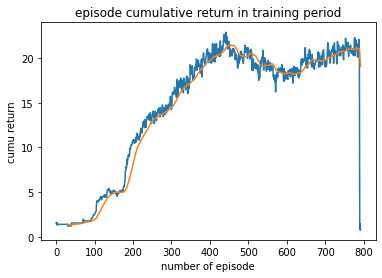

In [50]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
name = []
cumu_return = []
count = 0
for root,_,files in os.walk('./train_history_DDPG/cumulative_return'):
    for i in files:
        if i.endswith('csv') and 'checkpoint' not in i:
            name.append(i)     
name.sort()
for i in name:
    count+=1
    tmp = pd.read_csv(os.path.join('./train_history_DDPG/cumulative_return',i))
    cumu_return.append(tmp['0'].values[-1])
            
print('total episode:',count)
ma = pd.DataFrame(cumu_return).rolling(30).mean()
plt.title('episode cumulative return in training period')
plt.ylabel('cumu return')
plt.xlabel('number of episode')
plt.plot(cumu_return)
plt.plot(ma)
plt.show()

### Testing Plot

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (201, 9)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (201, 9)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (201, 9)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (201, 9)


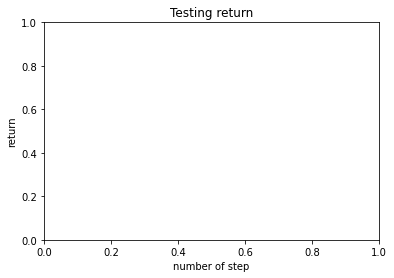

In [51]:
import os
import matplotlib.pyplot as plt

plt.title('Testing return')
plt.ylabel('return')
plt.xlabel('number of step')
DDPG_return = pd.read_csv('./train_history_DDPG_2022/cumulative_return/cumu_return2022-10-25 171720.csv')
PPO_return = pd.read_csv('./train_history_PPO_2022/cumulative_return/cumu_return2022-10-25 181911.csv')
DDPG_return.columns=['step','return']
PPO_return.columns=['step','return']
sp500 = DP.download_data(start_date = TEST_START_DATE,end_date = TEST_END_DATE,ticker_list = ['%5EGSPC'], time_interval='1D')
tlt = DP.download_data(start_date = TEST_START_DATE,end_date = TEST_END_DATE,ticker_list = ['TLT'], time_interval='1D')
vnq = DP.download_data(start_date = TEST_START_DATE,end_date = TEST_END_DATE,ticker_list = ['VNQ'], time_interval='1D')
vti = DP.download_data(start_date = TEST_START_DATE,end_date = TEST_END_DATE,ticker_list = ['VTI'], time_interval='1D')
dis = len(sp500['close'])-len(PPO_return)
tlt  = tlt.iloc[dis:].reset_index()
vnq  = vnq.iloc[dis:].reset_index()
vti  = vti.iloc[dis:].reset_index()

DDPG_return len: 191
PPO_return len: 191
sp500 len: 201


<function matplotlib.pyplot.show(close=None, block=None)>

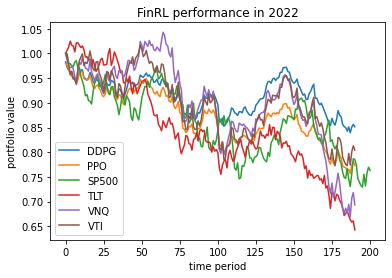

In [53]:
print('DDPG_return len:',len(DDPG_return))
print('PPO_return len:',len(PPO_return))
print('sp500 len:',len(sp500['close']))

plt.ylabel('portfolio value')
plt.xlabel('time period')
plt.title('FinRL performance in 2022')
plt.plot(DDPG_return['return'])
plt.plot(PPO_return['return'])
plt.plot((sp500['close'].pct_change().cumsum()+1).fillna(1))
plt.plot((tlt['close'].pct_change().cumsum()+1).fillna(1))
plt.plot((vnq['close'].pct_change().cumsum()+1).fillna(1))
plt.plot((vti['close'].pct_change().cumsum()+1).fillna(1))
plt.legend(['DDPG','PPO','SP500','TLT','VNQ','VTI'])

plt.show

In [54]:
print(DDPG_return['return'].iloc[-1]-1)
print(PPO_return['return'].iloc[-1]-1)

-0.14864794486370114
-0.22671993983974414
